In [ ]:
import numpy as np

In [ ]:
atts=np.load("/content/drive/My Drive/att_scores_out_3img/0.npy", allow_pickle=True)

In [ ]:
scores = atts.item().get('cross')

In [ ]:
print(len(scores))
for s in scores:
  print(s.shape)
print(scores[0][0:3][:, 4].shape)

10
(750, 12, 20, 36)
(750, 12, 36, 20)
(750, 12, 20, 36)
(750, 12, 36, 20)
(750, 12, 20, 36)
(750, 12, 36, 20)
(750, 12, 20, 36)
(750, 12, 36, 20)
(750, 12, 20, 36)
(750, 12, 36, 20)
(3, 20, 36)


## Language Encoder

In [ ]:
import json
import matplotlib.pyplot as plt
import numpy as np
import seaborn

dataset_path = "/content/drive/My Drive/att_scores_out_3img/test.json"

def get_question_tokens(ques_id):

  with open(dataset_path) as f:
    dataset = json.load(f)

  ques_string = dataset[ques_id]['sent'].lower()
  # ques_tokens = ['[cls]']
  ques_tokens = []
  ques_tokens.extend(ques_string.split())
  ques_tokens.append('[eos]')

  return ques_tokens

def plot_lang_attention(ques_id, layers, heads):

  sent = get_question_tokens(ques_id)
  sent = sent[:14]

  ques_id *= 3

  for layer in layers:
    for att_head in heads:

      sample = atts.item().get('lang')[layer][ques_id][att_head][1:14, 1:14]
      # sample = atts.item().get('lang')[layer][i0:i1][:,att_head,:14,:14].reshape(14,-1)

      fig, ax = plt.subplots(figsize=(6,6))
      ax.set_title("Image 0, Language layer %d, head %d" % (layer, att_head))
      seaborn.heatmap(sample, cmap="Blues")
      ax.xaxis.set_ticks_position('top')
      plt.rcParams['ytick.left'] = True
      plt.xticks(np.arange(len(sent))+0.5, sent, rotation=65)
      plt.yticks(np.arange(len(sent))+0.5, sent, rotation=0)
      ax.set_aspect("equal")
      ax.figure.axes[-1].yaxis.label.set_size(50)
      plt.show()

      sample = atts.item().get('lang')[layer][ques_id+1][att_head][1:14, 1:14]
      # sample = atts.item().get('lang')[layer][i0:i1][:,att_head,:14,:14].reshape(14,-1)

      fig, ax = plt.subplots(figsize=(6,6))
      ax.set_title("Image 1, Language layer %d, head %d" % (layer, att_head))
      seaborn.heatmap(sample, cmap="Blues")
      ax.xaxis.set_ticks_position('top')
      plt.rcParams['ytick.left'] = True
      plt.xticks(np.arange(len(sent))+0.5, sent, rotation=65)
      plt.yticks(np.arange(len(sent))+0.5, sent, rotation=0)
      ax.set_aspect("equal")
      ax.figure.axes[-1].yaxis.label.set_size(50)
      plt.show()

      sample = atts.item().get('lang')[layer][ques_id+2][att_head][1:14, 1:14]
      # sample = atts.item().get('lang')[layer][i0:i1][:,att_head,:14,:14].reshape(14,-1)

      fig, ax = plt.subplots(figsize=(6,6))
      ax.set_title("Image 2, Language layer %d, head %d" % (layer, att_head))
      seaborn.heatmap(sample, cmap="Blues")
      ax.xaxis.set_ticks_position('top')
      plt.rcParams['ytick.left'] = True
      plt.xticks(np.arange(len(sent))+0.5, sent, rotation=65)
      plt.yticks(np.arange(len(sent))+0.5, sent, rotation=0)
      ax.set_aspect("equal")
      ax.figure.axes[-1].yaxis.label.set_size(50)
      plt.show()

In [ ]:
ques_id = 0
# layers = [0, 1, 7, 8]
# heads = [0,2,4,6,8,11]
layers = range(0,9)
heads = range(0, 12)
plot_lang_attention(ques_id, layers, heads)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
ques_id = 2
# layers = [0, 1, 7, 8]
# heads = [0,2,4,6,8,11]
layers = range(0,9)
heads = range(0, 12)
plot_lang_attention(ques_id, layers, heads)

Output hidden; open in https://colab.research.google.com to view.

## Visual Encoder

In [ ]:
!pip install mxnet==1.6.0
!pip install -U d2l -f https://d2l.ai/whl.html

import sys
import csv
import base64
import time
%matplotlib inline
from d2l import mxnet as d2l
from mxnet import image, npx
import numpy as np
import matplotlib.pyplot as plt

npx.set_np()

maxInt = sys.maxsize

while True:
    # decrease the maxInt value by factor 10 
    # as long as the OverflowError occurs.
    try:
        csv.field_size_limit(maxInt)
        break
    except OverflowError:
        maxInt = int(maxInt/10)

FIELDNAMES = ["img_id", "img_h", "img_w", "objects_id", "objects_conf",
              "attrs_id", "attrs_conf", "num_boxes", "boxes", "features"]

def load_obj_tsv(fname, topk=None):

    data = []
    start_time = time.time()
    print("Start to load Faster-RCNN detected objects from %s" % fname)
    with open(fname) as f:
        reader = csv.DictReader(f, FIELDNAMES, delimiter="\t")
        for i, item in enumerate(reader):

            for key in ['img_h', 'img_w', 'num_boxes']:
                item[key] = int(item[key])
            
            boxes = item['num_boxes']
            decode_config = [
                ('objects_id', (boxes, ), np.int64),
                ('objects_conf', (boxes, ), np.float32),
                ('attrs_id', (boxes, ), np.int64),
                ('attrs_conf', (boxes, ), np.float32),
                ('boxes', (boxes, 4), np.float32),
                ('features', (boxes, -1), np.float32),
            ]
            for key, shape, dtype in decode_config:
                item[key] = np.frombuffer(base64.b64decode(item[key]), dtype=dtype)
                item[key] = item[key].reshape(shape)
                item[key].setflags(write=False)
            
            data.append(item)
            if topk is not None and len(data) == topk:
                break
    return data

rcnn_data = load_obj_tsv("/content/drive/My Drive/out_correct_order/test_obj36.tsv")

Looking in links: https://d2l.ai/whl.html
Requirement already up-to-date: d2l in /usr/local/lib/python3.6/dist-packages (0.14.3)
Start to load Faster-RCNN detected objects from /content/drive/My Drive/out_correct_order/test_obj36.tsv


In [ ]:
import json

dataset_path = "/content/drive/My Drive/att_scores_out_3img/test.json"

def get_question_tokens(ques_id):

  with open(dataset_path) as f:
    dataset = json.load(f)

  ques_string = dataset[ques_id]['sent'].lower()
  ques_tokens = ['[cls]']
  ques_tokens.extend(ques_string.split())
  ques_tokens.append('[eos]')

  return ques_tokens

def get_image_data(ques_id):

  scene_data = []

  with open(dataset_path) as f:
    dataset = json.load(f)

  img0_id = dataset[ques_id]['img0']
  img1_id = dataset[ques_id]['img1']
  img2_id = dataset[ques_id]['img2']

  for img_id in [img0_id, img1_id, img2_id]:
    for datum in rcnn_data:
      if datum['img_id'] == img_id:
        scene_data.append(datum)
  
  return scene_data

In [ ]:
def get_detected_labels(ques_id):

  scene_data = get_image_data(ques_id)
  with open("/content/drive/My Drive/att_scores_out/objects_vocab.txt") as f:
    objects = f.readlines()
  objects = [x.strip() for x in objects] 

  with open("/content/drive/My Drive/att_scores_out/attributes_vocab.txt") as f:
    attributes = f.readlines()
  attributes = [x.strip() for x in attributes] 


  scenes_obj = []
  scenes_attrs = []

  for data in scene_data:
    detected_obj = []
    for oid in data['objects_id']:
      detected_obj.append(objects[oid])
    scenes_obj.append(detected_obj)

  for data in scene_data:
    detected_attrs = []
    for aid in data['attrs_id']:
      detected_attrs.append(attributes[aid])
    scenes_attrs.append(detected_attrs)

  scene_labels = []
  for j, detected_obj in enumerate(scenes_obj):
    labels = []
    for i, o in enumerate(detected_obj):
      labels.append(str(i) + ': ' + o + ' ' + scenes_attrs[j][i])
    scene_labels.append(labels)

  return scene_labels

In [ ]:
p = get_detected_labels(0)

In [ ]:
def plot_visual_attention(ques_id, layers, heads):
  
  tmp_labels = get_detected_labels(ques_id)
  # labels = [row[:10] for row in tmp_labels]
  labels = tmp_labels

  ques_id *= 3

  for layer in layers:
    for att_head in heads:

      sample = atts.item().get('vision')[layer][ques_id][att_head][:19,:19]

      fig, ax = plt.subplots(figsize=(8,8))
      ax.set_title("Image 0, Vision layer %d, head %d" % (layer, att_head))
      seaborn.heatmap(sample, cmap="Blues")
      ax.xaxis.set_ticks_position('top')
      plt.rcParams['ytick.left'] = True
      plt.xticks(np.arange(len(labels[0][:19]))+0.5, labels[0][:19], rotation=90, fontsize=13)
      plt.yticks(np.arange(len(labels[0][:19]))+0.3, labels[0][:19], rotation=45, fontsize=13)
      ax.set_aspect("equal")
      # ax.figure.axes[-1].yaxis.label.set_size(25)
      plt.show()

      sample = atts.item().get('vision')[layer][ques_id+1][att_head][:19,:19]

      fig, ax = plt.subplots(figsize=(8,8))
      ax.set_title("Image 1, Vision layer %d, head %d" % (layer, att_head))
      seaborn.heatmap(sample, cmap="Blues")
      ax.xaxis.set_ticks_position('top')
      plt.rcParams['ytick.left'] = True
      plt.xticks(np.arange(len(labels[1][:19]))+0.5, labels[1][:19], rotation=90, fontsize=13)
      plt.yticks(np.arange(len(labels[1][:19]))+0.3, labels[1][:19], rotation=45, fontsize=13)
      ax.set_aspect("equal")
      # ax.figure.axes[-1].yaxis.label.set_size(25)
      plt.show()

      sample = atts.item().get('vision')[layer][ques_id+2][att_head][:19,:19]

      fig, ax = plt.subplots(figsize=(8,8))
      ax.set_title("Image 2, Vision layer %d, head %d" % (layer, att_head))
      seaborn.heatmap(sample, cmap="Blues")
      ax.xaxis.set_ticks_position('top')
      plt.rcParams['ytick.left'] = True
      plt.xticks(np.arange(len(labels[2][:19]))+0.5, labels[2][:19], rotation=90, fontsize=13)
      plt.yticks(np.arange(len(labels[2][:19]))+0.5, labels[2][:19], rotation=45, fontsize=13)
      ax.set_aspect("equal")
      # ax.figure.axes[-1].yaxis.label.set_size(25)
      plt.show()

In [ ]:
ques_id = 64
layers = range(0, 5)
heads = range(0, 12)

plot_visual_attention(ques_id, layers, heads)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
def plot_cross_attention(ques_id, img_id, layers, heads):

  tmp_labels = get_detected_labels(ques_id)
  sent = get_question_tokens(ques_id)

  # labels = [row[:10] for row in tmp_labels]
  labels = tmp_labels
  print(len(labels[0]))

  ques_id *= 3

  for layer in layers:
    for att_head in heads:

      sample = atts.item().get('cross')[layer][ques_id][att_head]
    
      if sample.shape[0] == 20:
       
        fig, ax = plt.subplots(figsize=(22,7))
        ax.set_title("Image 0, Language-vision, layer %d, head %d" % (layer, att_head))
        plt.rcParams['ytick.left'] = True
        sample = sample[:14, :36]
        seaborn.heatmap(sample, cmap="Blues")
        ax.xaxis.set_ticks_position('top')
        plt.xticks(np.arange(len(labels[0]))+0.5, labels[0], rotation=90, fontsize = 14)
        plt.yticks(np.arange(len(sent[:14]))+0.5, sent[:14], rotation=45, fontsize = 14)
        plt.show()
      if sample.shape[0] == 36:
        fig, ax = plt.subplots(figsize=(5,7))
        ax.set_title("Image 0, Vision-language, layer %d, head %d" % (layer, att_head), fontsize = 14)
        plt.rcParams['ytick.left'] = True
        sample = sample[:20, :14]
        seaborn.heatmap(sample, cmap="Blues")
        ax.xaxis.set_ticks_position('top')
        plt.yticks(np.arange(len(labels[0][:20]))+0.5, labels[0][:20], rotation=0, fontsize = 12)
        plt.xticks(np.arange(len(sent[:14]))+0.5, sent[:14], rotation=45, fontsize = 12)
        plt.show()

      sample = atts.item().get('cross')[layer][ques_id+1][att_head]
    
      if sample.shape[0] == 20:
       
        fig, ax = plt.subplots(figsize=(22,7))
        ax.set_title("Image 1, Language-vision, layer %d, head %d" % (layer, att_head))
        plt.rcParams['ytick.left'] = True
        sample = sample[:14, :36]
        seaborn.heatmap(sample, cmap="Blues")
        ax.xaxis.set_ticks_position('top')
        plt.xticks(np.arange(len(labels[1]))+0.5, labels[1], rotation=90, fontsize = 14)
        plt.yticks(np.arange(len(sent[:14]))+0.5, sent[:14], rotation=45, fontsize = 14)
        plt.show()
      if sample.shape[0] == 36:
        fig, ax = plt.subplots(figsize=(5,7))
        ax.set_title("Image 1, Vision-language, layer %d, head %d" % (layer, att_head), fontsize = 14)
        plt.rcParams['ytick.left'] = True
        sample = sample[:20, :14]
        seaborn.heatmap(sample, cmap="Blues")
        ax.xaxis.set_ticks_position('top')
        plt.yticks(np.arange(len(labels[1][:20]))+0.5, labels[1][:20], rotation=0, fontsize = 12)
        plt.xticks(np.arange(len(sent[:14]))+0.5, sent[:14], rotation=45, fontsize = 12)
        plt.show()

      sample = atts.item().get('cross')[layer][ques_id+2][att_head]
    
      if sample.shape[0] == 20:
       
        fig, ax = plt.subplots(figsize=(22,7))
        ax.set_title("Image 2, Language-vision, layer %d, head %d" % (layer, att_head))
        plt.rcParams['ytick.left'] = True
        sample = sample[:14, :36]
        seaborn.heatmap(sample, cmap="Blues")
        ax.xaxis.set_ticks_position('top')
        plt.xticks(np.arange(len(labels[2]))+0.5, labels[2], rotation=90, fontsize = 14)
        plt.yticks(np.arange(len(sent[:14]))+0.5, sent[:14], rotation=45, fontsize = 14)
        plt.show()
      if sample.shape[0] == 36:
        fig, ax = plt.subplots(figsize=(5,7))
        ax.set_title("Image 2, Vision-language, layer %d, head %d" % (layer, att_head), fontsize = 14)
        plt.rcParams['ytick.left'] = True
        sample = sample[:20, :14]
        seaborn.heatmap(sample, cmap="Blues")
        ax.xaxis.set_ticks_position('top')
        plt.yticks(np.arange(len(labels[2][:20]))+0.5, labels[2][:20], rotation=0, fontsize = 12)
        plt.xticks(np.arange(len(sent[:14]))+0.5, sent[:14], rotation=45, fontsize = 12)
        plt.show()

In [ ]:
ques_id = 0
img_id = 0
layers = range(0,9)
heads = range(0,12)
# layers = [0,2,3,5,6,10]
# heads = [0,6,11]
plot_cross_attention(ques_id, img_id, layers, heads)

Output hidden; open in https://colab.research.google.com to view.

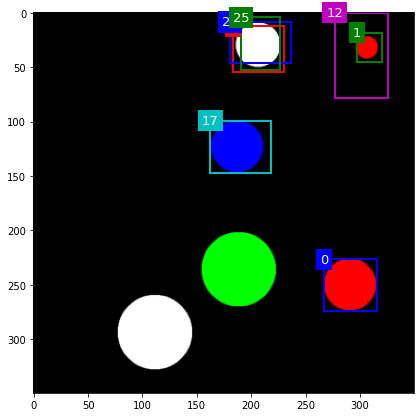

In [ ]:
from operator import itemgetter 

ques_id = 0
img_file = '0-img2.png'

plt.figure(figsize=(7,7))

img = image.imread(img_file).asnumpy()

labels = get_detected_labels(ques_id)[2]
for i, l in enumerate(labels):
  labels[i] = l.split(': ')[0]

img_feats = get_image_data(ques_id)[2]

to_display = [0,1,2,12,17,20,25]
fig = d2l.plt.imshow(img)

show_bboxes(fig.axes, itemgetter(*to_display)(img_feats['boxes']),
            itemgetter(*to_display)(labels))

In [ ]:
def show_bboxes(axes, bboxes, labels=None, colors=None):
    """Show bounding boxes."""
    def _make_list(obj, default_values=None):
        if obj is None:
            obj = default_values
        elif not isinstance(obj, (list, tuple)):
            obj = [obj]
        return obj
    labels = _make_list(labels)
    colors = _make_list(colors, ['b', 'g', 'r', 'm', 'c'])
    for i, bbox in enumerate(bboxes):
        color = colors[i % len(colors)]
        rect = d2l.bbox_to_rect(bbox, color)
        axes.add_patch(rect)
        if labels and len(labels) > i:
            text_color = 'k' if color == 'w' else 'w'
            axes.text(rect.xy[0], rect.xy[1], labels[i],
                      va='center', ha='center', fontsize=13, color=text_color,
                      bbox=dict(facecolor=color, lw=0))